
# TCP/IP Encapsulation Project – Student Guide (English)

**Goal:** Craft IPv4+TCP packets. On Linux/macOS, use raw sockets; on Windows, automatically fall back to **Scapy + Npcap**. <br>
**Flow:** CSV (Application Messages) → Notebook (Encapsulation Simulation) → Wireshark (Capture) → Report (Explanation) <br>
**Safety:** Educational use only. Prefer loopback/VM. Admin/root privileges usually required.


## Prerequisites
- **Linux/macOS**: `sudo jupyter lab` → capture `lo` in Wireshark → run `demo_send()`
- **Windows**:
  1) Install Wireshark/Npcap with *WinPcap API-compatible mode* + *Support loopback traffic*.
  2) `pip install scapy pandas`
  3) Run Jupyter **as Administrator**
  4) Capture **Npcap Loopback Adapter** in Wireshark
  5) Run `demo_send(iface='Npcap Loopback Adapter')`



## Step 1 — Load Your CSV (Input)
1. Place your CSV file (e.g., `group05_http_input.csv`) in the same folder as this notebook.
2. The CSV must contain the following columns: `msg_id, app_protocol, src_app, dst_app, message, timestamp`.
3. In the next cell, set `CSV_PATH` to your file name and run the cell.
4. Verify that the preview shows your rows correctly.


In [161]:
#TODO: Load CSV file with messages into pandas DataFrame, 

# Replace 'path_to_your_file.csv' with the actual file path
import pandas as pd
import scapy
filename = "group_http_input.csv" # "path_to_your_file.csv"
messages_df = pd.read_csv(filename)
print(messages_df.columns)


Index(['app_protocol', 'src_port', 'dst_port', 'message', 'timestamp'], dtype='object')



## Step 2 — Validate the Schema
The notebook will automatically check the CSV header. If a required column is missing, you will see an error message.
- If validation fails, fix your CSV and re-run Step 1.
- If it passes, continue to Step 3.


In [162]:
# TODO: Run the cell to validate the CSV file format

def validate_csv_format(df: pd.DataFrame):
    expected_columns = ["app_protocol", "src_port", "dst_port", "message", "timestamp"]
    for col in expected_columns:
        if col not in df.columns:
            raise ValueError(f"Missing expected column: {col}")
        
messages_df['message'] = messages_df['message'].fillna('')  # Fill NaN messages with empty strings
validate_csv_format(messages_df)



## Step 3 — Map to TCP/IP Layers (Encapsulation)
This notebook will map each application message to the TCP/IP stack:
- Application → Transport (e.g., TCP/UDP headers)
- Internet (IP headers)
- Link (frame headers/footers)

Just run the cell(s) in this section to see the derived structures.



In [163]:
# NOTE: Follow the step-by-step markdown cells above. Set paths only where indicated.
import socket, struct, random, time, platform
from typing import Optional

IS_WINDOWS = (platform.system() == 'Windows')
try:
    from scapy.all import IP as SCAPY_IP, TCP as SCAPY_TCP, Raw as SCAPY_Raw, send as scapy_send, get_if_list
    HAVE_SCAPY = True
except Exception as e:
    HAVE_SCAPY = False
    SCAPY_IMPORT_ERR = e
IS_WINDOWS, HAVE_SCAPY

(True, True)

In [164]:
# Function to calculate checksum
def checksum(data: bytes) -> int:
    if len(data) % 2:
        data += b'\0'
    res = sum(struct.unpack('!%dH' % (len(data)//2), data))
    while res >> 16:
        res = (res & 0xFFFF) + (res >> 16)
    return ~res & 0xFFFF

# Helper function to display the data 
def hexdump(data: bytes, width: int=16):
    for i in range(0, len(data), width):
        chunk = data[i:i+width]
        hex_bytes = ' '.join(f'{b:02x}' for b in chunk)
        ascii_bytes = ''.join(chr(b) if 32 <= b < 127 else '.' for b in chunk)
        print(f"{i:04x}  {hex_bytes:<{width*3}}  {ascii_bytes}")


In [165]:
def build_ip_header(src_ip: str, dst_ip: str, payload_len: int, proto: int=socket.IPPROTO_TCP) -> bytes:
    version_ihl = (4 << 4) + 5
    tos = 0
    total_length = 20 + payload_len
    identification = random.randint(0, 65535)
    flags_fragment = 0
    ttl = 64
    header_checksum = 0
    src = socket.inet_aton(src_ip)
    dst = socket.inet_aton(dst_ip)
    ip_header = struct.pack('!BBHHHBBH4s4s',
                             version_ihl, tos, total_length, identification,
                             flags_fragment, ttl, proto, header_checksum,
                             src, dst)
    chksum = checksum(ip_header)
    ip_header = struct.pack('!BBHHHBBH4s4s',
                             version_ihl, tos, total_length, identification,
                             flags_fragment, ttl, proto, chksum,
                             src, dst)
    return ip_header


In [166]:
def build_tcp_header(src_ip: str, dst_ip: str, src_port: int, dst_port: int, payload: bytes=b'',
                     seq: Optional[int]=None, ack_seq: int=0, flags: int=0x02, window: int=65535) -> bytes:
    if seq is None:
        seq = random.randint(0, 0xFFFFFFFF)
    doff_reserved = (5 << 4)
    checksum_tcp = 0
    urg_ptr = 0
    tcp_header = struct.pack('!HHLLBBHHH',
                              src_port, dst_port, seq, ack_seq,
                              doff_reserved, flags, window,
                              checksum_tcp, urg_ptr)
    placeholder = 0
    protocol = socket.IPPROTO_TCP
    tcp_length = len(tcp_header) + len(payload)
    pseudo_header = struct.pack('!4s4sBBH',
                                socket.inet_aton(src_ip), socket.inet_aton(dst_ip),
                                placeholder, protocol, tcp_length)
    chksum = checksum(pseudo_header + tcp_header + payload)
    tcp_header = struct.pack('!HHLLBBH H H',
                              src_port, dst_port, seq, ack_seq,
                              doff_reserved, flags, window,
                              chksum, urg_ptr)
    return tcp_header


### Cross‑Platform Transport
- Linux/macOS: raw sockets (we include the IP header)
- Windows: Scapy + Npcap fallback (raw TCP sockets are blocked by the OS)

In [167]:
class RawTcpTransport:
    def __init__(self, src_ip: str, dst_ip: str, src_port: int, dst_port: int, iface: Optional[str]=None):
        self.src_ip = src_ip
        self.dst_ip = dst_ip
        self.src_port = src_port
        self.dst_port = dst_port
        self.iface = iface
        self.windows_fallback = IS_WINDOWS
        if not self.windows_fallback:
            self.sock = socket.socket(socket.AF_INET, socket.SOCK_RAW, socket.IPPROTO_RAW)
        else:
            if not HAVE_SCAPY:
                raise RuntimeError(
                    f"Windows detected but Scapy is not available: {SCAPY_IMPORT_ERR}.\n"
                    "Install with: pip install scapy. Ensure Npcap is installed with loopback support."
                )

    def encapsulate(self, data: bytes, flags: int=0x02) -> bytes:
        tcp = build_tcp_header(self.src_ip, self.dst_ip, self.src_port, self.dst_port, data, flags=flags)
        ip  = build_ip_header(self.src_ip, self.dst_ip, len(tcp) + len(data))
        return ip + tcp + data

    def send(self, data: bytes, flags: int=0x02):
        if not self.windows_fallback:
            pkt = self.encapsulate(data, flags=flags)
            self.sock.sendto(pkt, (self.dst_ip, 0))
        else:
            scapy_pkt = SCAPY_IP(src=self.src_ip, dst=self.dst_ip)/SCAPY_TCP(sport=self.src_port, dport=self.dst_port, flags=flags)/SCAPY_Raw(data)
            chosen_iface = self.iface
            if chosen_iface is None and self.dst_ip in ("127.0.0.1", "::1"):
                chosen_iface = "Npcap Loopback Adapter"
            scapy_send(scapy_pkt, verbose=False, iface=chosen_iface)


In [168]:
# find interface name for Windows
if IS_WINDOWS and HAVE_SCAPY:
    try:
        print('\n'.join(get_if_list()))
    except Exception as e:
        print('Could not list interfaces:', e)


\Device\NPF_{BF05A2D4-D6DC-4ECE-AC68-D0E15F754126}
\Device\NPF_{D21AF0D1-395F-413F-B150-B9E92E923DC9}
\Device\NPF_{5FDA45D8-344D-435A-949A-2AA495A6FC7B}
\Device\NPF_{D24EFAEB-3220-4818-809E-CE2CEF368930}
\Device\NPF_{EB0F97F6-9711-4400-9C21-45323E28CBE2}
\Device\NPF_{EFC87204-8C68-403A-BB59-05BEDA738790}
\Device\NPF_{870BEBDE-5368-4D7A-B344-B611A015D24D}
\Device\NPF_Loopback
\Device\NPF_{324BB3F9-7DE0-4C6D-B68F-F6597416537C}


In [169]:
# Preview packet structure
src_ip = '127.0.0.1'
dst_ip = '127.0.0.1'
src_port = random.randint(1024, 65535)
dst_port = 12345
payload = b'Hello Packet (preview)'
pkt_preview = build_ip_header(src_ip, dst_ip, 20 + len(payload)) + build_tcp_header(src_ip, dst_ip, src_port, dst_port, payload) + payload
hexdump(pkt_preview)


0000  45 00 00 3e 02 20 00 00 40 06 7a 98 7f 00 00 01   E..>. ..@.z.....
0010  7f 00 00 01 8b df 30 39 fc 98 5f f1 00 00 00 00   ......09.._.....
0020  50 02 ff ff 85 54 00 00 48 65 6c 6c 6f 20 50 61   P....T..Hello Pa
0030  63 6b 65 74 20 28 70 72 65 76 69 65 77 29         cket (preview)



## Step 4 — Capture in Wireshark
1. Start capture in Wireshark.
2. Run the transmit/simulation cells in this notebook.
3. Observe packets appearing in Wireshark (timing may vary by system).
4. Stop the capture and save the file as `.pcap`.

### Suggested Wireshark Filters
- `ip.addr == 127.0.0.1 && tcp.port == 12345`
- `tcp.flags.syn == 1 && tcp.flags.ack == 0 && tcp.port == 12345`
- `tcp.flags.push == 1 && tcp.flags.ack == 1 && tcp.port == 12345`



## Step 5 — Generate/Synthesize Traffic
The notebook will simulate the transmission of your messages. You do not need to change parameters unless instructed in comments.
- Make sure Wireshark is open and ready to capture on your active interface.
- Consider applying a simple filter (e.g., `tcp port 80` for HTTP) to focus the view.


In [170]:
# Create transport instance
src_ip = '127.0.0.1'
dst_ip = '127.0.0.1'
src_port = random.randint(1024, 65535)
dst_port = 12345
iface = "\\Device\\NPF_Loopback"  # Set to "Npcap Loopback Adapter" on Windows if needed
transport = RawTcpTransport(src_ip, dst_ip, src_port, dst_port, iface=iface)

In [171]:
def demo_send(num_packets: int=3, delay_sec: float=1.0, flags: int=0x02):
    for i in range(num_packets):
        payload = f'Hello Packet {i}'.encode()
        transport.send(payload, flags=flags)
        time.sleep(delay_sec)


### Run (commented for safety)
- Linux/macOS: `demo_send()`
- Windows loopback: `demo_send(iface='Npcap Loopback Adapter')`
- Try flags: `flags=0x18` (PSH+ACK), `0x10` (ACK), `0x01` (FIN), `0x04` (RST)


In [172]:
# demo_send(num_packets=3, delay_sec=1.0, flags=0x02)
# demo_send(num_packets=3, flags=0x18)


### Send Messages from CSV file 

Iterate over the rows and send message by message

In [173]:
#Send messages from CSV file
for index, row in messages_df.iterrows():
    # Extract message details from the DataFrame row
    message = row['message']
    message = f"test message {index}" if not message else message
    # Send the message using the RawTcpTransport class
    # (You may need to adjust flags and other parameters as needed)
    
    #TODO: uncomment the line below to send the messages
    transport.send(message.encode(), flags=0x18)  # Example with PSH+ACK flags
    
    time.sleep(0.1)  # Optional delay between messages

c:\Users\ofira\anaconda3\Lib\site-packages\scapy\sendrecv.py:485: SyntaxWarning: 'iface' has no effect on L3 I/O send(). For multicast/link-local see https://scapy.readthedocs.io/en/latest/usage.html#multicast
  warnings.warn(



## Step 6 — Analyze and Explain
In your **report**:
- Explain how the CSV application messages became packets/frames through encapsulation.
- Use **Wireshark screenshots** to illustrate headers, ports, and payloads.
- Link observations back to your CSV rows (e.g., message IDs).


Detailed Analysis of Network Traffic
From the Application Layer to the Network Layer (Including Screenshot Explanation)

End-to-End Packet Encapsulation Process Across the Jupyter Notebook:

Throughout the Jupyter Notebook, the packet encapsulation process is demonstrated end to end, starting from the raw data loaded from the CSV file and continuing until the final structured packets are produced. The CSV file represents application-layer information, including message content, protocol type, ports, and timestamps. This data serves as the initial payload generated by the application.

As the notebook progresses, the application data is gradually processed and enriched with additional metadata that simulates lower network layers. The messages are logically wrapped with transport-layer details, such as source and destination ports, mimicking TCP behavior and demonstrating how application data is prepared for reliable transmission. In later stages, network-layer information is added, including IP addressing, which completes the encapsulation process.

By the end of the notebook, the original CSV-based messages have been transformed into fully structured packets that reflect the layered network model. This step-by-step process clearly illustrates how high-level application data is encapsulated into transport and network layers, providing a practical and code-based understanding of packet construction and data flow through the network stack.

Network Traffic Analysis Using Wireshark:

1. Application Layer – HTTP
At the application layer, the captured traffic clearly shows the use of the HTTP protocol, which is a text-based application-level protocol based on the client–server model.

From the packet details visible in the capture, an HTTP request is identified:
GET /product?id=5 HTTP/1.1
This request indicates that the client is attempting to retrieve a resource (/product) from the server while passing a query parameter (id=5).
The request is written in plain ASCII text, which is characteristic of HTTP/1.1 and allows tools like Wireshark to display the content directly.

Key points at the Application Layer:
Protocol: HTTP
Request type: GET
Resource: /product
Parameter: id=5
HTTP version: 1.1

This layer is responsible for defining what action is being requested and how the data should be interpreted by the receiving application.

2. Transport Layer – TCP
The HTTP data is encapsulated within TCP segments, as seen in the Wireshark packet list and packet details.
From the capture:
Source Port: 41676
Destination Port: 12345
Protocol: TCP
The source port (41676) is an ephemeral (temporary) port used by the client, while the destination port (12345) represents the service the client is attempting to communicate with.

TCP provides:
Reliable, connection-oriented communication
Sequencing and acknowledgment of data
Flow control
The presence of flags such as PSH and ACK indicates that application data is being pushed to the receiving application and acknowledged at the transport level.
Although TCP handles the delivery mechanics, it does not interpret the HTTP data itself — it simply treats it as a byte stream.

3. Network Layer – IP
At the network layer, the communication is handled using IPv4.
From the packet details:
Source IP: 127.0.0.1
Destination IP: 127.0.0.1
This address is the loopback address, which means the communication occurs entirely within the same machine (localhost).
Even though the packets are not sent over an external network, they still traverse the full protocol stack, making them valid for layered analysis.
The IP layer is responsible for:
Logical addressing
Packet routing
Encapsulation of TCP segments into IP packets

4. Screenshot Explanation – Packet List View (First Screenshot)
In the first screenshot (packet list view), we can observe:
Multiple TCP packets exchanged between 127.0.0.1 and 127.0.0.1
Repeated communication attempts between source port 41676 and destination port 12345
Clear indication that TCP is the protocol in use
Packet lengths that match the size of TCP segments carrying application data
This view provides a high-level overview of the traffic flow and shows how packets are exchanged over time between the client and server processes.

5. Screenshot Explanation – Packet Details & Payload (Second Screenshot)
The second screenshot shows the detailed dissection of a single packet, including:
Frame information (packet size and capture interface)
Loopback interface
IPv4 header with source and destination addresses
TCP header with ports, sequence number, acknowledgment number, and payload length
Raw data section containing the HTTP request
In the payload section, the ASCII decoding clearly reveals the HTTP request:
GET /product?id=5 HTTP/1.1
This confirms how:
Application-layer data (HTTP)
Is encapsulated inside a TCP segment
Which is further encapsulated inside an IP packet
Wireshark allows us to visually trace this encapsulation step-by-step.

6.End-to-End Layered Flow Summary

The application generates an HTTP GET request.
The request is passed to the transport layer and encapsulated in a TCP segment.
TCP adds port numbers, sequence information, and control flags.
The network layer encapsulates the TCP segment in an IPv4 packet with source and destination IP addresses.
The packet is transmitted via the loopback interface and processed locally

Final Summary
The captured traffic demonstrates a complete and clear example of layered communication, starting from the Application Layer (HTTP), through the Transport Layer (TCP), and down to the Network Layer (IP).
Despite being local (localhost) communication, the capture effectively illustrates how data is structured, encapsulated, and transmitted across protocol layers according to the TCP/IP model.

Packet List Overview
The following screenshot presents the packet list view in Wireshark, showing multiple TCP packets exchanged between the client and the server over the loopback interface (127.0.0.1).



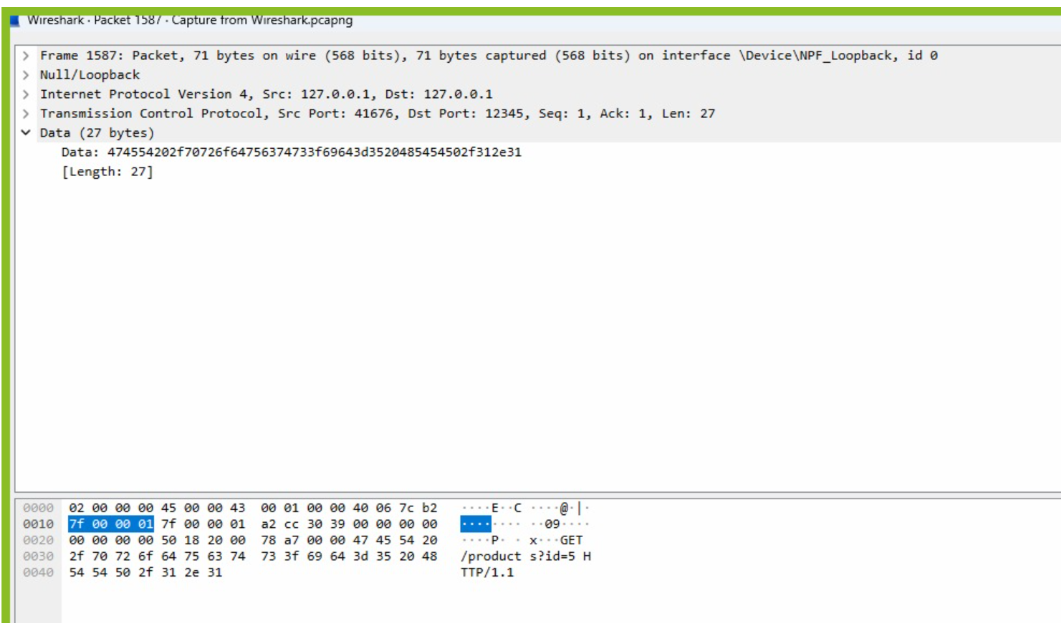

Packet Details and Payload Analysis
The screenshot below shows a detailed inspection of a single packet, including the IPv4 header, TCP header, and the HTTP request visible in the payload.

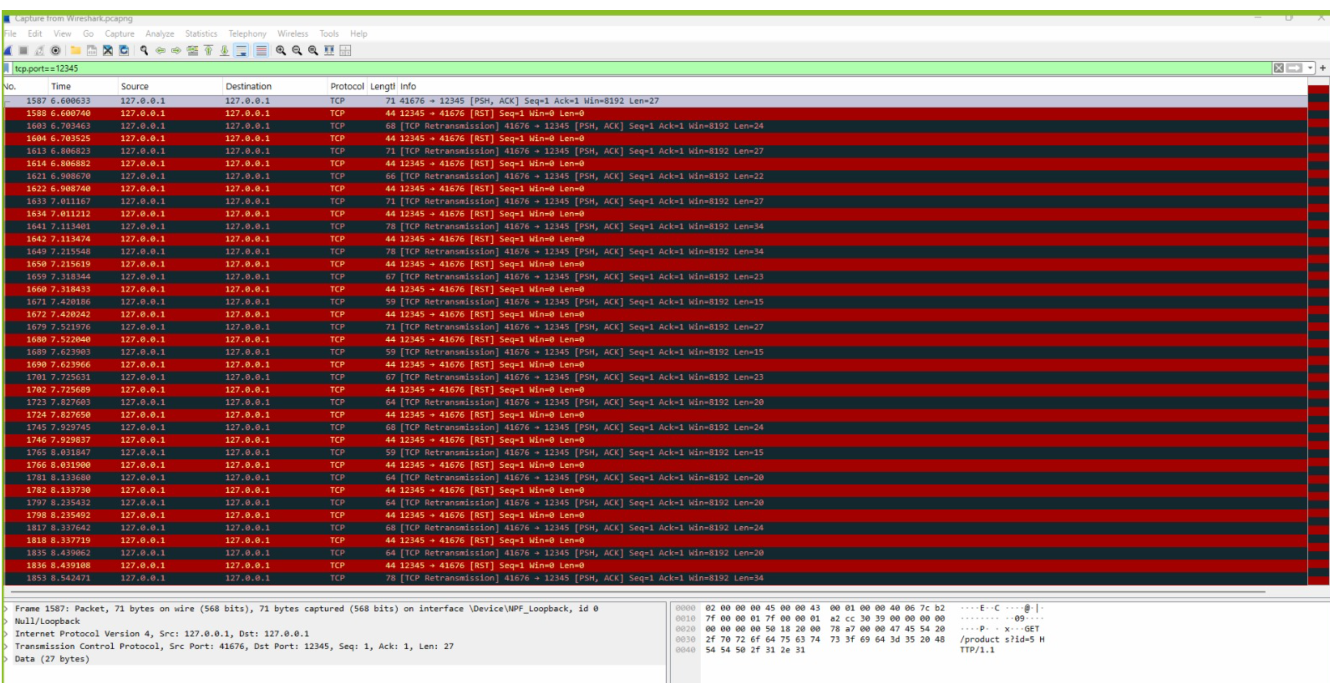


## Deliverables Checklist
- [ ] CSV input file.
- [ ] Executed notebook (with outputs).
- [ ] Wireshark .pcap capture.
